## QUESTION 1

In [235]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l
import zipfile


In [236]:
# Extract the contents of the 'archive.zip' file into the 'extracts' directory
with zipfile.ZipFile("archive.zip", "r") as z:
    z.extractall("extracts")

# Read the CSV file 'car_web_scraped_dataset.csv' into a pandas DataFrame
car_dataframe = pd.read_csv("extracts/car_web_scraped_dataset.csv")

In [237]:

car_dataframe.head()

,name,year,miles,color,condition,price
0,Kia Forte,2022,"41,406 miles","Gray exterior, Black interior","No accidents reported, 1 Owner","$15,988"
1,Chevrolet Silverado 1500,2021,"15,138 miles","White exterior, Black interior","1 accident reported, 1 Owner","$38,008"
2,Toyota RAV4,2022,"32,879 miles","Silver exterior, Unknown interior","No accidents reported, 1 Owner","$24,988"
3,Honda Civic,2020,"37,190 miles","Blue exterior, Black interior","No accidents reported, 1 Owner","$18,998"
4,Honda Civic,2020,"27,496 miles","Black exterior, Black interior","No accidents reported, 1 Owner","$19,498"


## Preparing the data

In [238]:
# Clean numeric columns by removing ($ , ',', miles) and converting to int
car_dataframe['miles'] = car_dataframe['miles'].replace('[\,miles]', '', regex=True).str.strip().astype(int)
car_dataframe['price'] = pd.to_numeric(car_dataframe['price'].replace('[\$,]','', regex=True), errors='coerce')
car_dataframe['year'] = car_dataframe['year'].astype(int)

car_dataframe.shape, car_dataframe.head()

((2840, 6),
                        name  year  miles                              color  \
 0                 Kia Forte  2022  41406      Gray exterior, Black interior   
 1  Chevrolet Silverado 1500  2021  15138     White exterior, Black interior   
 2               Toyota RAV4  2022  32879  Silver exterior, Unknown interior   
 3               Honda Civic  2020  37190      Blue exterior, Black interior   
 4               Honda Civic  2020  27496     Black exterior, Black interior   
 
                         condition  price  
 0  No accidents reported, 1 Owner  15988  
 1    1 accident reported, 1 Owner  38008  
 2  No accidents reported, 1 Owner  24988  
 3  No accidents reported, 1 Owner  18998  
 4  No accidents reported, 1 Owner  19498  )

#### Processing data to add additional columns

In [239]:

# Creating column for number of accidents
car_dataframe['number_of_accidents'] = car_dataframe['condition'].str.split(',', expand=True)[0]
car_dataframe['number_of_accidents'] = car_dataframe['number_of_accidents'].str.extract('(\d+)').astype(float)
car_dataframe['number_of_accidents'] = car_dataframe['number_of_accidents'].fillna(0)

# creating column for number of owners
car_dataframe['number_of_owners' ] = car_dataframe['condition'].str.split(',', expand=True)[1]
car_dataframe['number_of_owners'] = car_dataframe['number_of_owners'].str.extract('(\d+)').astype(float)
car_dataframe['number_of_owners'] = car_dataframe['number_of_owners'].fillna(0)

#### Creating input features and terget labels

In [240]:
# Create inputs (year and miles) and targets (price)
year_miles_input = car_dataframe[['year', 'miles']] 
targets = car_dataframe['price']

# Create inputs (year, number of accidents, and miles)
year_miles_aacidents_input = car_dataframe[['miles', 'year', 'number_of_accidents']] 


# Remove Nans from inputs usng imputation with means
year_miles_input = year_miles_input.fillna(year_miles_input.mean())
year_miles_aacidents_input = year_miles_aacidents_input.fillna(year_miles_aacidents_input.mean())
targets = targets.fillna(targets.mean())

# Apply log transformation to targets for normalization
targets = np.log(targets)

# Generating tensors from inputs and targets
year_miles_input = torch.tensor(year_miles_input.to_numpy(),dtype=torch.float)
year_miles_aacidents_input = torch.tensor(year_miles_aacidents_input.to_numpy(),dtype=torch.float)
targets = torch.tensor(targets.to_numpy(),dtype=torch.float).reshape(-1, 1)


#### Splitting data into training set and testing set

In [241]:
# Define training and test data sizes
data_size = len(car_dataframe)
train_size = int(data_size * 0.7)

# Creating training set and test set for two features training
year_miles_train_input = year_miles_input[:train_size]
year_miles_test_input = year_miles_input[train_size:]

# Creating training set and test set for three features training
year_miles_accidents_train_input = year_miles_aacidents_input[:train_size]
year_miles_accidents_test_input = year_miles_aacidents_input[train_size:]

# Split the labels
train_labels = targets[:train_size]
test_labels = targets[train_size:]


Standardizing the training features by scaling to follow the Gausian Distribution

In [242]:

# Standardize inputs
year_miles_train_input = (year_miles_train_input - year_miles_train_input.mean()) / year_miles_train_input.std()

# Standardize inputs
year_miles_accidents_train_input = (year_miles_accidents_train_input - year_miles_accidents_train_input.mean()) / year_miles_accidents_train_input.std()


#### Data class for defining the data

In [243]:
class LabRegressionData(d2l.DataModule):

    def __init__(self, X, y, num_train=1000, num_val=1000,
                 batch_size=32):
        """Creates a LabRegressionData object with the given input and output data"""
        super().__init__()
        self.save_hyperparameters()

    def get_dataloader(self, train):
        """Get the data loader for the regression data"""
        i = slice(0, self.num_train) if train else slice(self.num_train, None)
        return self.get_tensorloader((self.X, self.y), train, i)

    def get_tensorloader(self, tensors, train, indices=slice(0, None)):
        """Get the tensor loader for the regression data"""
        tensors = tuple(a[indices] for a in tensors)
        dataset = torch.utils.data.TensorDataset(*tensors)
        return torch.utils.data.DataLoader(dataset, self.batch_size,
                                        shuffle=train)

## Defining the model 

In [244]:
class LabLinearRegressionScratch(d2l.Module): 
    """The linear regression model implemented from scratch."""
    def __init__(self, num_inputs, lr, sigma=0.01):
        """
        Initialize the LabLinearRegressionScratch model.
        """
        super().__init__()
        self.save_hyperparameters()
        self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True)
        self.b = torch.zeros(1, requires_grad=True)


    def forward(self, X):
        """
        Perform forward pass of the linear regression model.
        """
        return torch.matmul(X, self.w) + self.b
    

    def loss(self, y_hat, y):
        """
        Calculate the loss function.
        """
        l = (y_hat - y)**2/2
        return l.mean()
    

## Defining the optimization algorithm

In [245]:
class SGD(d2l.HyperParameters):  
    """Minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.save_hyperparameters()

    def step(self):
        for param in self.params:
            param -= self.lr * param.grad

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.zero_()

In [246]:
@d2l.add_to_class(LabLinearRegressionScratch)  
def configure_optimizers(self):
    return SGD([self.w, self.b], self.lr)

## Training

In [247]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
    return batch

In [248]:
@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
    """
    Fits the model for one epoch of training and validation.
    """
    self.model.train()
    for batch in self.train_dataloader:
        loss = self.model.training_step(self.prepare_batch(batch))
        self.optim.zero_grad()
        with torch.no_grad():
            loss.backward()
            if self.gradient_clip_val > 0: 
                self.clip_gradients(self.gradient_clip_val, self.model)
            self.optim.step()
        self.train_batch_idx += 1
    if self.val_dataloader is None:
        return
    self.model.eval()
    for batch in self.val_dataloader:
        with torch.no_grad():
            self.model.validation_step(self.prepare_batch(batch))
        self.val_batch_idx += 1

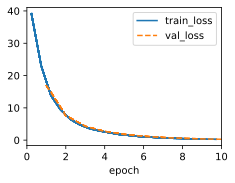

In [249]:
# Training a linear regression model from scratch using the LabLinearRegressionScratch class.
scratchmodelA = LabLinearRegressionScratch(2, 0.01)
data = LabRegressionData(X=year_miles_train_input, y=train_labels, num_train=1000, num_val=1000, batch_size=32)
scratchtrainer = d2l.Trainer(max_epochs=10)
scratchtrainer.fit(scratchmodelA, data)


(a) ii. Prediction for 5 examples


In [250]:
# THESE WILL BE USED FOR BOTH QUESTION1 AND QUESTION 2

# Sample five test data from the held out test set using the two features (year and miles)
five_sample_test_data = year_miles_test_input[:5]
five_sample_test_labels = test_labels[:5]

# Sample five random  test data from the held out test set using the three features (year, miles and no of accidents)
five_sample_test_data2 = year_miles_accidents_test_input[:5]
five_sample_test_labels2 = test_labels[:5]

In [251]:
# Utility functions to be used for testing in all  models with two features (year and miles)
def scaleTestData(test_data):
    return (test_data - year_miles_input.mean()) / year_miles_input.std()

In [252]:
# Predicting for five sample test data using the linear regression model from scratch
predicted = scratchmodelA(scaleTestData(five_sample_test_data)).detach().numpy()
predicted = np.exp(np.ravel(predicted))  # Flatten the array

# Print the predicted and actual values with the sampled test data and features
pd.DataFrame({
    'Years': five_sample_test_data[:, 0],
    'Mileage': five_sample_test_data[:, 1], 
    'Actual': np.exp(np.ravel(five_sample_test_labels)), 
    'Predicted': predicted
})


,Years,Mileage,Actual,Predicted
0,2021.0,23145.0,70498.000000,15148.315430
1,2020.0,32544.0,19497.996094,16199.578125
2,2019.0,119342.0,20999.005859,30070.855469
3,2022.0,8972.0,32000.003906,13691.549805
4,2018.0,68049.0,22997.996094,20867.966797


(a) iii. Evaluation Using Average Squared Difference (MSE)

In [253]:
# Evaluating the scratchmodel from the held out test set using the Two features (year and mileage)
predictions_scratchA = scratchmodelA(scaleTestData(year_miles_test_input))
avg_square_diff_scratchA = nn.MSELoss()(predictions_scratchA, test_labels)
print("Average Square Difference:", avg_square_diff_scratchA.item())

Average Square Difference: 0.5441356897354126


## QUESTION 1 b

i.  Training LabLinearRegressionScratch on features mileage, years and number of accidents (input features) and price as the target

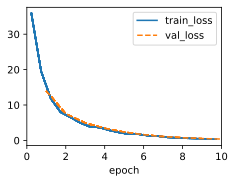

In [254]:
scratchmodelB = LabLinearRegressionScratch(3, 0.01)
data2 = LabRegressionData(X=year_miles_accidents_train_input, y=train_labels)
scratchtrainer2 = d2l.Trainer(max_epochs=10)
scratchtrainer2.fit(scratchmodelB, data2)

1b ii. Prediction for 5 examples using the utility function defined in question 1a ii above

In [255]:
# Utility functions to be used for testing in all  models with three features (year no_of_accidents and miles)
def scaleTestData2(test_data):
    return (test_data - year_miles_accidents_test_input.mean()) / year_miles_accidents_test_input.std()

In [256]:

predicted2 = scratchmodelB(scaleTestData2(five_sample_test_data2)).detach().numpy()
predicted2 = np.exp(np.ravel(predicted2))  # Flatten the array

# Print the predicted and actual values with the sampled test data and features
pd.DataFrame({
    'Years': five_sample_test_data2[:, 0],
    'Mileage': five_sample_test_data2[:, 1], 
    'No of Accidents': five_sample_test_data2[:, 2], 
    'Actual': np.exp(np.ravel(five_sample_test_labels2)), 
    'Predicted': predicted2
})


,Years,Mileage,No of Accidents,Actual,Predicted
0,23145.0,2021.0,0.0,70498.000000,13237.354492
1,32544.0,2020.0,0.0,19497.996094,14501.126953
2,119342.0,2019.0,0.0,20999.005859,33634.527344
3,8972.0,2022.0,0.0,32000.003906,11537.361328
4,68049.0,2018.0,0.0,22997.996094,20460.890625


1b iii. Evaluation Using Average Squared Difference (MSE)

In [257]:
# Evaluating the scratchmodel from the held out test set using the three features
predictions_scratchB = scratchmodelB(scaleTestData2(year_miles_accidents_test_input))
avg_square_diff_scratchB = nn.MSELoss()(predictions_scratchB, test_labels)
print("Average Square Difference:", avg_square_diff_scratchB.item()) 

Average Square Difference: 0.6961788535118103


## QUESTION 2 CONCISE IMPLEMENTATION

#### Defining the Concise Linear Regression Model

In [258]:
class LinearRegressionConcise(d2l.Module):
    def __init__(self, lr):
        super().__init__()
        self.save_hyperparameters()
        self.net = nn.LazyLinear(1)
        self.net.weight.data.normal_(0, 0.01)
        self.net.bias.data.fill_(0)


    def forward(self, X):
        return self.net(X)
    

    def loss(self, y_hat, y):
        fn = nn.MSELoss()
        return fn(y_hat, y)
    

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), self.lr)

    
    def get_w_b(self):
        return (self.net.weight.data, self.net.bias.data)

### Training with concise Linear Regression

2 a. i. Training Using Mileage and year

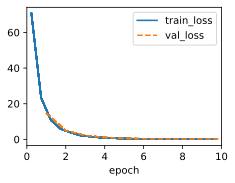

In [259]:
# Training the concise model on the two features (year and miles)
concisemodelA = LinearRegressionConcise(lr=0.01)
data3 = LabRegressionData(X=year_miles_train_input, y=train_labels)
concisetrainerA = d2l.Trainer(max_epochs=10)
concisetrainerA.fit(concisemodelA, data3)

2a ii.  Predictions for five examples using the same test examples as used for the previous two models in question 1


In [260]:
# Making predictions on the five sampled test data using the concise model
predicted3 = concisemodelA(scaleTestData(five_sample_test_data)).detach().numpy()
predicted3 = np.exp(np.ravel(predicted3))  # Flatten the array

pd.DataFrame({
    'Years': five_sample_test_data[:, 0],
    'Mileage': five_sample_test_data[:, 1], 
    'Actual': np.exp(np.ravel(five_sample_test_labels)), 
    'Predicted': predicted3
})

,Years,Mileage,Actual,Predicted
0,2021.0,23145.0,70498.000000,27838.779297
1,2020.0,32544.0,19497.996094,26163.412109
2,2019.0,119342.0,20999.005859,14734.333008
3,2022.0,8972.0,32000.003906,30572.089844
4,2018.0,68049.0,22997.996094,20690.667969


2a iii. Evaluation Using Average Squared Difference (MSE)

In [261]:
# Evaluating the concisemodelA from the held out test set using the two features (year and miles)
predictions_conciseA = concisemodelA(scaleTestData(year_miles_test_input))
avg_square_diff_conciseA = nn.MSELoss()(predictions_conciseA, test_labels)
print("Average Square Difference:",avg_square_diff_conciseA.item()) 

Average Square Difference: 0.13760627806186676


Question 2b: Training Using Mileage, year and number of accidents

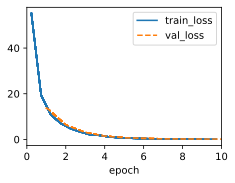

In [262]:
# Training the concise model on the three features (year, miles and no of accidents)
concisemodelB = LinearRegressionConcise(lr=0.01)
data4 = LabRegressionData(X=year_miles_accidents_train_input, y=train_labels)
concisetrainerB = d2l.Trainer(max_epochs=10)
concisetrainerB.fit(concisemodelB, data4)

2b ii. Predictions for 5  examples using the same test examples as used for the previous three models on year, mileage and number of accidents input features

In [263]:
# Making predictions on the five sampled test data using the concise model
predicted4 = concisemodelB(scaleTestData2(five_sample_test_data2)).detach().numpy()
predicted4 = np.exp(np.ravel(predicted4))  # Flatten the array

# Print the predicted and actual values with the sampled test data and features
pd.DataFrame({
    'Years': five_sample_test_data2[:, 0],
    'Mileage': five_sample_test_data2[:, 1], 
    'No of Accidents': five_sample_test_data2[:, 2], 
    'Actual': np.exp(np.ravel(five_sample_test_labels2)), 
    'Predicted': predicted4
})


,Years,Mileage,No of Accidents,Actual,Predicted
0,23145.0,2021.0,0.0,70498.000000,28816.666016
1,32544.0,2020.0,0.0,19497.996094,27369.201172
2,119342.0,2019.0,0.0,20999.005859,16990.130859
3,8972.0,2022.0,0.0,32000.003906,31147.013672
4,68049.0,2018.0,0.0,22997.996094,22523.425781


2b iii.  Evaluation the concisemodelB Using Average Squared Difference (MSE) 

In [264]:
# Evaluating the concisemodelA from the held out test set using the three features (year, no_of_accidents and miles)
predictions_conciseB = concisemodelB(scaleTestData(year_miles_accidents_test_input))
avg_square_diff_conciseB = nn.MSELoss()(predictions_conciseB, test_labels)
print("Average Square Difference:",avg_square_diff_conciseB.item()) 

Average Square Difference: 2.1547932624816895
